Домашку будет легче делать в колабе (убедитесь, что у вас runtype с gpu).

# Задание 1 (3 балла)

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) с помощью tensorflow аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты:
1) добавьте лемматизацию в предобработку (любым способом)  
2) измените размер окна в большую или меньшую сторону
3) измените размерность итоговых векторов

Выберете несколько не похожих по смыслу слов (не таких как в семинаре), и протестируйте полученные эмбединги (найдите ближайшие слова и оцените качество, как в семинаре).
Постарайтесь обучать модели как можно дольше и на как можно большем количестве данных. (Но если у вас мало времени или ресурсов, то допустимо взять поменьше данных и поставить меньше эпох)

In [ ]:
pip install pymystem3

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

from IPython.display import Image
from IPython.core.display import HTML
import re
%matplotlib inline

In [ ]:
# additional libraries
from pymystem3 import Mystem
m = Mystem()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
wiki = open('/content/drive/MyDrive/wiki_data.txt').read().split('\n')

In [6]:
# здесь добавлена лемматизация
def preprocess(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [m.lemmatize(token)[0] for token in tokens if token]
    return tokens

In [ ]:
vocab = Counter()

for text in wiki:
    vocab.update(preprocess(text))

vocab

In [8]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

In [9]:
sentences = []

for text in wiki:
    tokens = preprocess(text)
    if not tokens:
        continue
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

# SKIP GRAM


In [10]:
# skip gram
X = []
y = []

window = 7
for sent in sentences[:1000]:
    for i in range(len(sent)-1):
        word = sent[i] # target
        context = sent[max(0, i-window):i] + sent[i+1:i+window]  # context (слова до и после целевого)
        # в начале и в конце окно будет неполным, но это не страшно

        for context_word in context:
            X.append(word)
            y.append(context_word)

In [11]:
X[1], y[1]

(10334, 9525)

In [12]:
len(X), len(y)

(3004304, 3004304)

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [24]:
# инициализируем модель
model = tf.keras.Sequential()

# первым добавляем эмбединг слой
model.add(tf.keras.layers.Embedding(input_dim=len(word2id),
                                    input_length=1,
                                    output_dim=200)) # также указываем желаемый размер эмбединга
# flat размерность эмбедингов
model.add(tf.keras.layers.Flatten())

# И теперь 1 реальный слой, который называется полносвязным
model.add(tf.keras.layers.Dense(len(word2id),
                                activation='softmax'))


model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy')

In [19]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1, 200)            2449400   
                                                                 
 flatten_1 (Flatten)         (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 12247)             2461647   
                                                                 
Total params: 4911047 (18.73 MB)
Trainable params: 4911047 (18.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [20]:
# обучение
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=10)

Epoch 1/10
2855/2855 [==============================] - 48s 16ms/step - loss: 7.3411 - val_loss: 7.1041
Epoch 2/10
2855/2855 [==============================] - 31s 11ms/step - loss: 7.0007 - val_loss: 6.9498
Epoch 3/10
2855/2855 [==============================] - 31s 11ms/step - loss: 6.8366 - val_loss: 6.8684
Epoch 4/10
2855/2855 [==============================] - 30s 11ms/step - loss: 6.7117 - val_loss: 6.8320
Epoch 5/10
2855/2855 [==============================] - 31s 11ms/step - loss: 6.6119 - val_loss: 6.8243
Epoch 6/10
2855/2855 [==============================] - 31s 11ms/step - loss: 6.5308 - val_loss: 6.8343
Epoch 7/10
2855/2855 [==============================] - 31s 11ms/step - loss: 6.4641 - val_loss: 6.8563
Epoch 8/10
2855/2855 [==============================] - 31s 11ms/step - loss: 6.4081 - val_loss: 6.8838
Epoch 9/10
2855/2855 [==============================] - 31s 11ms/step - loss: 6.3611 - val_loss: 6.9137
Epoch 10/10
2855/2855 [==============================] - 31s 11m

dict_keys(['loss', 'val_loss'])


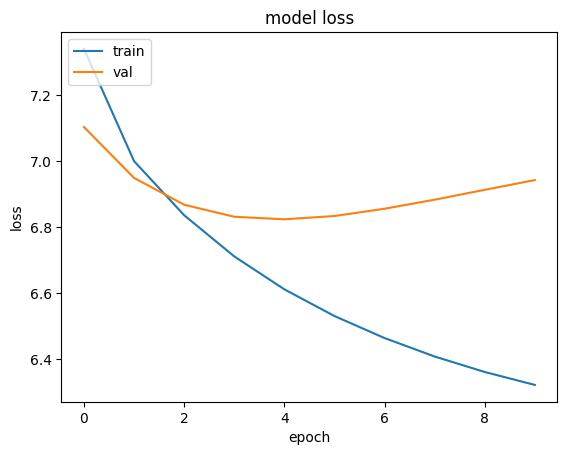

In [21]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# видно, что после 4й эпохи ошибка на валидации начала расти. Принято решение снизить кол-во эпох до 4

In [25]:
# обучение
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=4)

Epoch 1/4
2855/2855 [==============================] - 39s 13ms/step - loss: 7.3419 - val_loss: 7.1060
Epoch 2/4
2855/2855 [==============================] - 31s 11ms/step - loss: 7.0005 - val_loss: 6.9493
Epoch 3/4
2855/2855 [==============================] - 30s 10ms/step - loss: 6.8364 - val_loss: 6.8693
Epoch 4/4
2855/2855 [==============================] - 30s 10ms/step - loss: 6.7113 - val_loss: 6.8330


dict_keys(['loss', 'val_loss'])


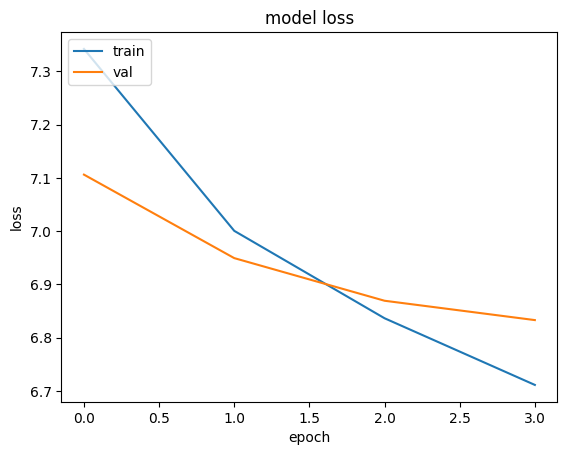

In [26]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
model.layers

In [28]:
# веса embedding слоя
model.layers[0].get_weights()[0].shape

(12247, 200)

In [29]:
# веса полносвязного слоя
model.layers[2].get_weights()[0].shape

(200, 12247)

In [31]:
embeddings_1 = model.layers[0].get_weights()[0]
embeddings_2 = model.layers[2].get_weights()[0].T
embeddings = np.mean([embeddings_1, embeddings_2], axis=0)

In [32]:
embeddings.shape

(12247, 200)

In [34]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

In [36]:
most_similar('мама', embeddings)

['мама',
 'ярость',
 'телефильм',
 'пробовать',
 'ценить',
 'ада',
 'сатира',
 'наказывать',
 'переделывать',
 'вкус']

In [37]:
most_similar('жизнь', embeddings)

['жизнь',
 'посвящать',
 'рассказывать',
 'жить',
 'свой',
 'последний',
 'вселенная',
 'событие',
 'наш',
 'ребенок']

In [ ]:
# сомнительное качество...

# CBOW



In [38]:
X = []
y = []

window = 5
for sent in sentences[:10000]:
    for i in range(len(sent)-1):
        word = sent[i]
        context = sent[max(0, i-window):i] + sent[i+1:i+window]

        X.append(context)
        y.append(word)

In [39]:
# оригинальные контексты
X[:10]

[[6622, 9525, 276, 6974],
 [10334, 9525, 276, 6974, 12173],
 [10334, 6622, 276, 6974, 12173, 655],
 [10334, 6622, 9525, 6974, 12173, 655, 586],
 [10334, 6622, 9525, 276, 12173, 655, 586, 10334],
 [10334, 6622, 9525, 276, 6974, 655, 586, 10334, 6622],
 [6622, 9525, 276, 6974, 12173, 586, 10334, 6622, 11905],
 [9525, 276, 6974, 12173, 655, 10334, 6622, 11905, 12173],
 [276, 6974, 12173, 655, 586, 6622, 11905, 12173, 7274],
 [6974, 12173, 655, 586, 10334, 11905, 12173, 7274, 3930]]

In [40]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=10, padding='post')
y = np.array(y)

In [41]:
# контексты после паддинга
X

array([[ 6622,  9525,   276, ...,     0,     0,     0],
       [10334,  9525,   276, ...,     0,     0,     0],
       [10334,  6622,   276, ...,     0,     0,     0],
       ...,
       [ 4458,  8590, 12173, ...,   633,     0,     0],
       [ 8590, 12173, 12173, ...,     0,     0,     0],
       [12173, 12173,   658, ...,     0,     0,     0]], dtype=int32)

In [42]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [47]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(word2id),
                                    input_length=10,
                                    output_dim=200))

# 2 отличие - нужно усреднить контекст в 1 вектор
model.add(tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1)))

model.add(tf.keras.layers.Dense(len(word2id), activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='sparse_categorical_crossentropy')

In [44]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 10, 100)           1224700   
                                                                 
 lambda (Lambda)             (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 12247)             1236947   
                                                                 
Total params: 2461647 (9.39 MB)
Trainable params: 2461647 (9.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [45]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=10)

Epoch 1/10
2045/2045 [==============================] - 55s 26ms/step - loss: 6.7879 - val_loss: 6.2289
Epoch 2/10
2045/2045 [==============================] - 20s 10ms/step - loss: 5.9598 - val_loss: 5.8835
Epoch 3/10
2045/2045 [==============================] - 21s 10ms/step - loss: 5.6277 - val_loss: 5.7362
Epoch 4/10
2045/2045 [==============================] - 19s 9ms/step - loss: 5.4222 - val_loss: 5.6689
Epoch 5/10
2045/2045 [==============================] - 20s 10ms/step - loss: 5.2795 - val_loss: 5.6382
Epoch 6/10
2045/2045 [==============================] - 19s 9ms/step - loss: 5.1740 - val_loss: 5.6310
Epoch 7/10
2045/2045 [==============================] - 19s 9ms/step - loss: 5.0926 - val_loss: 5.6354
Epoch 8/10
2045/2045 [==============================] - 19s 9ms/step - loss: 5.0277 - val_loss: 5.6481
Epoch 9/10
2045/2045 [==============================] - 18s 9ms/step - loss: 4.9748 - val_loss: 5.6618
Epoch 10/10
2045/2045 [==============================] - 19s 9ms/step

dict_keys(['loss', 'val_loss'])


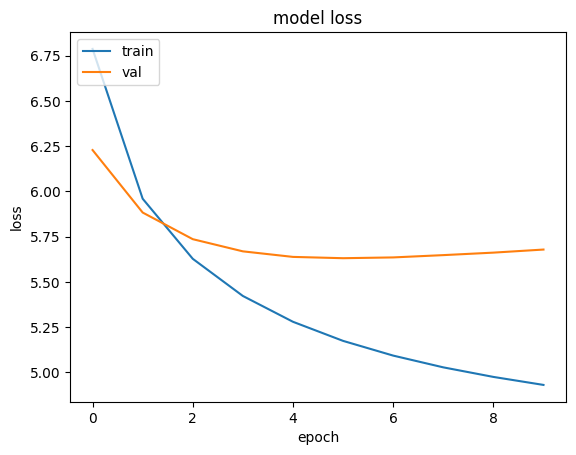

In [46]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# интересно, но ситуация аналогичная.. Опять снизим кол-во эпох

In [48]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=4)

Epoch 1/4
2045/2045 [==============================] - 57s 27ms/step - loss: 6.5662 - val_loss: 6.0009
Epoch 2/4
2045/2045 [==============================] - 26s 13ms/step - loss: 5.6874 - val_loss: 5.6824
Epoch 3/4
2045/2045 [==============================] - 23s 11ms/step - loss: 5.3130 - val_loss: 5.5703
Epoch 4/4
2045/2045 [==============================] - 23s 11ms/step - loss: 5.0633 - val_loss: 5.5364


dict_keys(['loss', 'val_loss'])


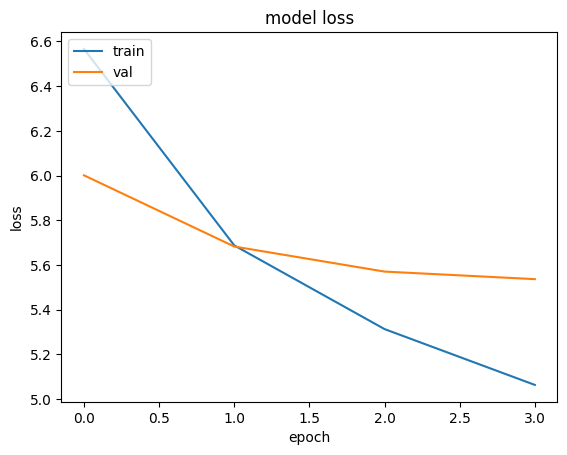

In [49]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [50]:
model.layers

In [51]:
# веса embedding слоя
model.layers[0].get_weights()[0].shape

(12247, 200)

In [52]:
# веса полносвязного слоя
model.layers[2].get_weights()[0].shape

(200, 12247)

In [53]:
embeddings_1 = model.layers[0].get_weights()[0]
embeddings_2 = model.layers[2].get_weights()[0].T
embeddings = np.mean([embeddings_1, embeddings_2], axis=0)

In [54]:
embeddings.shape

(12247, 200)

In [55]:
most_similar('мама', embeddings)

['мама',
 'слушать',
 'полюбить',
 'звать',
 'энни',
 'нравиться',
 'плакать',
 'влюбляться',
 'бобби',
 'мечта']

In [56]:
most_similar('жизнь', embeddings)

['жизнь',
 'самоубийство',
 'покончить',
 'повседневный',
 'вести',
 'служение',
 'уносить',
 'жизненный',
 'посвящать',
 'здоровый']

In [ ]:
# CBOW отрабатывает лучше

# ОБУЧЕНИЕ С Negative sampling


In [57]:
vocab_size = len(id2word)

In [119]:
# skip gram
def gen_batches_sg(sentences, window = 7, batch_size=1000):

    # параметр window задает его целиком
    # нам нужно поделить его пополам на левую и правую часть
    # когда делится неровно, то левая часть больше на 1
    left_context_length = (window/2).__ceil__() # округлить в большую сторону
    right_context_length = window // 2 # округлить в меньшую сторону

    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)

                    X_target.append(word)
                    X_context.append(np.random.randint(vocab_size))
                    y.append(0)

                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [120]:
# cbow
def gen_batches_cbow(sentences, window = 7, batch_size=1000):

    # параметр window задает его целиком
    # нам нужно поделить его пополам на левую и правую часть
    # когда делится неровно, то левая часть больше на 1
    left_context_length = (window/2).__ceil__() # округлить в большую сторону
    right_context_length = window // 2 # округлить в меньшую сторону

    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]

                X_target.append(word)
                X_context.append(context)
                y.append(1)

                X_target.append(np.random.randint(vocab_size))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = tf.keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

In [121]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(1,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Flatten()(embeddings_context)

dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context],
                       outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [122]:
model.fit(gen_batches_sg(sentences[:19000], window=5),
          validation_data=gen_batches_sg(sentences[19000:],  window=5),
          batch_size=1000,
          steps_per_epoch=10000,
          validation_steps=30,
         epochs=5)

Epoch 1/5
10000/10000 [==============================] - 108s 11ms/step - loss: 0.6220 - accuracy: 0.5844 - val_loss: 0.6278 - val_accuracy: 0.5813
Epoch 2/5
10000/10000 [==============================] - 68s 7ms/step - loss: 0.6125 - accuracy: 0.5904 - val_loss: 0.6085 - val_accuracy: 0.5940
Epoch 3/5
10000/10000 [==============================] - 70s 7ms/step - loss: 0.6084 - accuracy: 0.5931 - val_loss: 0.6085 - val_accuracy: 0.5870
Epoch 4/5
10000/10000 [==============================] - 73s 7ms/step - loss: 0.6060 - accuracy: 0.5932 - val_loss: 0.6012 - val_accuracy: 0.5925
Epoch 5/5
10000/10000 [==============================] - 68s 7ms/step - loss: 0.6035 - accuracy: 0.5940 - val_loss: 0.6031 - val_accuracy: 0.5924


In [123]:
SG_embeddings = model.layers[2].get_weights()[0]

In [63]:
most_similar('мама', embeddings)

['мама',
 'лиза',
 'тома',
 'пес',
 'бри',
 'бен',
 'мистер',
 'лиззи',
 'билли',
 'гроувер']

In [64]:
most_similar('жизнь', embeddings)

['жизнь',
 'жизненный',
 'семейный',
 'сознание',
 'счастие',
 'рыбак',
 'месть',
 'горожанин',
 'самоубийство',
 'сексуальный']

In [ ]:
# уже гораздо лучше, чем обучение без NS

In [124]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(10,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings_context)
dot = tf.keras.layers.Dot(1)([target, context])

# полученную близость нужно преобразовать в вероятность
# когда она одна используется не софтмакс и сигмоида
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context],
                       outputs=outputs)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [125]:
model.fit(gen_batches_cbow(sentences[:19000], window=5),
          validation_data=gen_batches_cbow(sentences[19000:],  window=5),
          batch_size=1000,
          steps_per_epoch=5000,
          validation_steps=30,
         epochs=5)

Epoch 1/5
5000/5000 [==============================] - 124s 25ms/step - loss: 0.5461 - accuracy: 0.6698 - val_loss: 0.5374 - val_accuracy: 0.6737
Epoch 2/5
5000/5000 [==============================] - 54s 11ms/step - loss: 0.5176 - accuracy: 0.6846 - val_loss: 0.5186 - val_accuracy: 0.6818
Epoch 3/5
5000/5000 [==============================] - 49s 10ms/step - loss: 0.5001 - accuracy: 0.6912 - val_loss: 0.5074 - val_accuracy: 0.6862
Epoch 4/5
5000/5000 [==============================] - 49s 10ms/step - loss: 0.4892 - accuracy: 0.6961 - val_loss: 0.4937 - val_accuracy: 0.6949
Epoch 5/5
5000/5000 [==============================] - 50s 10ms/step - loss: 0.4798 - accuracy: 0.6999 - val_loss: 0.5063 - val_accuracy: 0.6882


In [126]:
cbow_embeddings = model.layers[2].get_weights()[0]

In [68]:
most_similar('мама', embeddings)

['мама',
 'подруга',
 'тетя',
 'дедушка',
 'дочка',
 'возлюбленная',
 'невеста',
 'миссис',
 'прасковья',
 'приятель']

In [69]:
most_similar('жизнь', embeddings)

['жизнь',
 'работа',
 'время',
 'идея',
 'картина',
 'когда',
 'путь',
 'состояние',
 'общество',
 'свой']

In [ ]:
# по субъективной визуальной оценке cbow показал лучший результат


# Задание 2 (3 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

In [70]:
pip install gensim

In [100]:
import gensim

# additional libraries
from pymystem3 import Mystem
m = Mystem()

In [101]:
wiki = open('/content/drive/MyDrive/wiki_data.txt').read().split('\n')

In [102]:
# здесь добавлена лемматизация
def preprocess(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [m.lemmatize(token)[0] for token in tokens if token]
    return tokens

In [103]:
texts = [preprocess(text) for text in wiki]

In [93]:
w2v = gensim.models.Word2Vec(texts,
                             cbow_mean=0,
                             ns_exponent=0.74,
                             sample=2e-5,
                             vector_size=200,
                             min_count=25,
                             max_vocab_size=10000,
                             window=7,
                             epochs=7,
                             sg=1,
                             negative=13)

In [94]:
# не очень понимаю, почему это слово до этого было, а теперь его нет -__-
w2v.wv.most_similar('мама')

KeyError: "Key 'мама' not present in vocabulary"

In [104]:
'мама' in texts

False

In [95]:
w2v.wv.most_similar('жизнь')

[('любовь', 0.6348199844360352),
 ('посвящать', 0.6154699921607971),
 ('жить', 0.6077913045883179),
 ('много', 0.6047798991203308),
 ('любить', 0.5935583114624023),
 ('ради', 0.5830317139625549),
 ('писать', 0.5829160809516907),
 ('жена', 0.5720778107643127),
 ('сердце', 0.5709187388420105),
 ('сон', 0.5700564384460449)]

In [105]:
ft = gensim.models.FastText(texts,
                             cbow_mean=0,
                             ns_exponent=0.74,
                             sample=2e-5,
                             vector_size=200,
                             min_count=25,
                             max_vocab_size=10000,
                             window=7,
                             epochs=7,
                             sg=1,
                             negative=13)

In [107]:
ft.wv.most_similar('жизнь')

[('любовь', 0.6552883386611938),
 ('писать', 0.6439223885536194),
 ('писатель', 0.6379637718200684),
 ('жить', 0.6378950476646423),
 ('любить', 0.6290308833122253),
 ('дух', 0.6274406909942627),
 ('творчество', 0.6185585856437683),
 ('смерть', 0.6155495047569275),
 ('стихотворение', 0.6135231256484985),
 ('литературный', 0.6063507199287415)]

# Задание 3 (4 балла)

Используя датасет для классификации (labeled.csv) и простую нейронную сеть (последняя модель в семинаре), оцените качество полученных эмбедингов в задании 1 и 2 (4 набора эмбедингов), также проверьте 1 любую из предобученных моделей с rus-vectores (но только не tayga_upos_skipgram_300_2_2019).
Какая модель показывает наилучший результат?

Убедитесь, что для каждой модели вы корректно воспроизводите пайплайн предобработки (в 1 задании у вас лемматизация, не забудьте ее применить к датасету для классификации; у выбранной предобученной модели может быть своя специфичная предобработка - ее нужно воспроизвести)

In [109]:
data = pd.read_csv('/content/drive/MyDrive/labeled (1).csv')

In [110]:
data['norm_text'] = data.comment.apply(preprocess)

In [111]:
data

,comment,toxic,norm_text
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0,"[верблюд, за, что, дебил, бл]"
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,"[хохол, это, отдушина, затюканый, россиянин, м..."
2,Собаке - собачья смерть\n,1.0,"[собака, собачий, смерть]"
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,"[страница, обновлять, дебил, это, тоже, не, ос..."
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,"[ты, не, убеждать, 6, пдф, в, том, что, скрипа..."
...,...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0,"[вонючий, совковый, скот, прибегать, и, ныть, ..."
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0,"[а, кто, любить, гоблин, тупорылый, что, или, ..."
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0,"[посмотреть, утомленный, солнце, 2, и, оказыва..."
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0,"[крымотред, нарушать, правило, раздел, т, в, н..."


In [112]:
vocab = Counter()

for text in data['norm_text']:
    vocab.update(text)

filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

len(filtered_vocab)

6256

In [113]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

In [114]:
X = []

for tokens in data['norm_text']:
    ids = [word2id[token] for token in tokens if token in word2id]
    X.append(ids)

In [115]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)
y = data.toxic.values

In [127]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [ ]:
# у меня почему-то ничего не загружается по ссылке https://rusvectores.org/ru/models/, поэтому не получилось проверить предобученную модель :(
# но вставил код, как я бы это сделал по тетрадки семинара

In [ ]:
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('эмбединги', binary=False)

In [ ]:
mapping = {}

for line in open('./ru-rnc.map'):
    ms, ud = line.strip('\n').split()
    mapping[ms] = ud

In [ ]:
from pymystem3 import Mystem
m = Mystem()

In [ ]:
def normalize_mystem(text):
    tokens = []
    norm_words = m.analyze(text)
    for norm_word in norm_words:
        if 'analysis' not in norm_word:
            continue

        if not len(norm_word['analysis']):
            lemma = norm_word['text']
            pos = 'UNKN'
        else:
            lemma = norm_word["analysis"][0]["lex"].lower().strip()
            pos = norm_word["analysis"][0]["gr"].split(',')[0]
            pos = pos.split('=')[0].strip()
        pos = mapping[pos]
        tokens.append(lemma+'_'+pos)

    return tokens

In [ ]:
# сложно сказать надо ли что-то еще делать, т.к. в тетрадки семинара на этом все.
# Далее я пробовал обучить последнюю модель тетрадки и оценить все эмбединги

In [137]:
ft = gensim.models.FastText(texts + data['norm_text'].values.tolist(), window=10, epochs=10)

In [138]:
weights = np.zeros((len(word2id), 100))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights[i] = ft.wv[word]


    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights[i] = ft.wv['опрагпллирао']

In [153]:
inputs = tf.keras.layers.Input(shape=(100,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто
# # обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100,
                                       trainable=False,
                                       weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [157]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=30)

Epoch 1/30
428/428 [==============================] - 2s 4ms/step - loss: 0.4931 - accuracy: 0.7657 - val_loss: 0.4923 - val_accuracy: 0.7920
Epoch 2/30
428/428 [==============================] - 1s 3ms/step - loss: 0.4840 - accuracy: 0.7734 - val_loss: 0.4817 - val_accuracy: 0.8044
Epoch 3/30
428/428 [==============================] - 1s 3ms/step - loss: 0.4770 - accuracy: 0.7780 - val_loss: 0.4764 - val_accuracy: 0.8058
Epoch 4/30
428/428 [==============================] - 1s 3ms/step - loss: 0.4715 - accuracy: 0.7853 - val_loss: 0.4747 - val_accuracy: 0.7989
Epoch 5/30
428/428 [==============================] - 1s 3ms/step - loss: 0.4668 - accuracy: 0.7881 - val_loss: 0.4661 - val_accuracy: 0.8086
Epoch 6/30
428/428 [==============================] - 2s 4ms/step - loss: 0.4625 - accuracy: 0.7910 - val_loss: 0.4613 - val_accuracy: 0.8183
Epoch 7/30
428/428 [==============================] - 2s 5ms/step - loss: 0.4595 - accuracy: 0.7950 - val_loss: 0.4592 - val_accuracy: 0.8169
Epoch 

In [168]:
embeddings_1 = model.layers[1].get_weights()[0]
embeddings_2 = model.layers[3].get_weights()[0].T

In [169]:
# embeddings
fasttext_emb = ft
w2v_emb = w2v
sg_emb = SG_embeddings
cbow_emb = cbow_embeddings
last_model_embeddings = np.mean([embeddings_1, embeddings_2], axis=0)

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


In [177]:
fasttext_embs = [word for word, prob in fasttext_emb.wv.most_similar('жизнь')]
w2v_embs = [word for word, prob in w2v_emb.wv.most_similar('жизнь')]
sg_embs = most_similar('жизнь', sg_emb)
cbow_embs = most_similar('жизнь', cbow_emb)
last_model_embs = most_similar('жизнь', last_model_embeddings)

In [189]:
pd.DataFrame({'fasttext_embs': fasttext_embs, 'w2v_embs': w2v_embs, 'sg_embs': sg_embs,
              'cbow_embs': cbow_embs, 'last_model_embs': last_model_embs})

,fasttext_embs,w2v_embs,sg_embs,cbow_embs,last_model_embs
0,жизненно,любовь,жизнь,жизнь,жизнь
1,жиздра,посвящать,весить,часть,жизненный
2,пожизненно,жить,тронуть,подсветка,детство
3,рознь,много,попадать,нищий,творчество
4,боязнь,любить,конечный,блядь,чувство
5,жизнедеятельность,ради,выливать,сатана,болезнь
6,жизор,писать,уменьшение,палатка,любовь
7,жизнеспособность,жена,счетчик,PAD,покой
8,жизненный,сердце,инф,сплошной,сознание
9,живьем,сон,ответственность,ты,душа
